In [857]:
import pandas as pd
import numpy as np
import scipy as sp
import mne
from os import path as op
from itertools import combinations
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import shap

# from mne.stats import spatio_temporal_cluster_1samp_test
from scipy import stats as stats

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split,permutation_test_score
from utils import *
from xgboost import XGBClassifier, XGBRegressor
from mne.stats import permutation_cluster_1samp_test


from mne.datasets import sample
from mne.decoding import GeneralizingEstimator, LinearModel, SlidingEstimator,get_coef, cross_val_multiscore
from mne.io.constants import FIFF

from scipy.stats import wilcoxon



In [2]:
def cross_classification(dataset, X, y):
    '''Function to take an EEG dataset and run classification at
       each timepoint within an epoch'''

    timepoints = []

    for i in tqdm(range(0,dataset['n_samples'])):

        train_time_idx = np.arange(i, X.shape[1], dataset['n_samples']) # gives us each sensor at time point i (for training)

        xgb_pipeline = Pipeline([
                    ('scaler', StandardScaler()),  # Standardize features
                    ('xgb', XGBClassifier(random_state=42))  # XGB classifier
                ])
        
        xgb_pipeline_cv = Pipeline([
                    ('scaler', StandardScaler()),  # Standardize features
                    ('xgb', XGBClassifier(random_state=42))  # XGB classifier
                ])
        
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        le = LabelEncoder() # for xgboost classifier

        X_train = X[:,train_time_idx]
        y = le.fit_transform(y)

        # fit model using training time point in the outer loop
        xgb_pipeline.fit(X_train, y)

        for j in range(0,dataset['n_samples']):
            
            # set up train/test data based on indices
            test_time_idx = np.arange(j, X.shape[1], dataset['n_samples']) # gives us each sensor at time point j (for testing)
            X_test = X[:,test_time_idx]

            # run 10-fold CV to train/test at the same time point    
            if i == j:

                xgb_results = cross_validate(xgb_pipeline_cv, X_train, y, cv=cv, scoring=['accuracy'], return_estimator=True)
                test_score = np.mean(xgb_results['test_accuracy'])
            
            # otherwise train on time i and test on time j
            else:
                # predict other time points from trained model
                test_score = xgb_pipeline.score(X_test,y)
                
                
            timepoints.append((i,j,test_score))

    return timepoints

In [3]:
def timewise_classification(dataset, stim):
    '''Function to take an EEG dataset and run classification at
       each timepoint within an epoch'''

    # set up structures for storing results
    dataset[f'timepoint_modeling_{stim}'] = {}
    timewise_accuracies = np.array([])

    if stim=='labels3':
        # Set up Feature/Target structures for classification
        X = dataset['X'][dataset['labels_range']==1]
        y = dataset['labels3'][dataset['labels_range']==1]

    elif stim=='solution':
        X = dataset['X'][dataset['solution_idx']]
        y = dataset['labels_correct']

    else:
        X = dataset['X'][dataset['eq_idx']]
        y = dataset['labels_correct']


    n_samples = dataset['n_samples']

    for i in tqdm(range(0,n_samples+1)):

        time_idx = np.arange(i, X.shape[1], n_samples) # gives us each sensor at time point i

        le = LabelEncoder() # for xgboost classifier

        y = le.fit_transform(y)
        X_sub = X[:,time_idx]

        xgb_pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardize features
            ('xgb', XGBClassifier(random_state=42))  # XGB classifier
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        xgb_results = cross_validate(xgb_pipeline, X_sub, y, cv=cv, scoring=['accuracy'], return_estimator=True)

        dataset[f'timepoint_modeling_{stim}'][str(i)] = xgb_results

        # add to list of average model performance across CV folds at each time point
        timewise_accuracies = np.append(timewise_accuracies, np.mean(xgb_results['test_accuracy']))


    dataset[f'timepoint_acc_{stim}'] = timewise_accuracies

    return dataset

In [9]:
def get_shap_values(estimator, X, background_samples=100, verbose=None):
    """Retrieve the SHAP values from an estimator ending with XGBoost.

    Parameters
    ----------
    estimator : object
        A fitted estimator from scikit-learn with XGBoost as final step.
    X : array-like
        Input data to compute SHAP values for.
    background_samples : int
        Number of background samples to use for SHAP explainer.
    verbose : bool
        Verbosity level.

    Returns
    -------
    shap_values : array
        The mean absolute SHAP values across samples for each feature and time point.
    """
    # Get the estimator
    est = estimator
    while hasattr(est, "steps"):
        est = est.steps[-1][1]

    squeeze_first_dim = False
    
    # If SlidingEstimator, loop across estimators
    if hasattr(est, "estimators_"):
        shap_values_list = []
        
        for ei, this_est in enumerate(est.estimators_):
            if ei == 0:
                print("  Extracting SHAP values from SlidingEstimator.")
            
            # Get the XGBoost model from the pipeline
            xgb_model = this_est.steps[-1][1]  # Get XGBoost from pipeline
            
            # Transform the data through the preprocessing steps
            X_transformed = X[:, :, ei]  # Get data for this time point
            for step_name, transformer in this_est.steps[:-1]:
                X_transformed = transformer.transform(X_transformed)
            
            # Create SHAP explainer
            # Use a subset of the data as background for efficiency
            background_indices = np.random.choice(
                X_transformed.shape[0], 
                size=min(background_samples, X_transformed.shape[0]), 
                replace=False
            )
            background = X_transformed[background_indices]
            
            explainer = shap.TreeExplainer(xgb_model, background)
            
            # Calculate SHAP values for all samples
            shap_vals = explainer.shap_values(X_transformed)
            
            # If binary classification, shap_vals might be 3D, take the positive class
            if len(shap_vals.shape) == 2:
                mean_shap = np.mean(np.abs(shap_vals), axis=0)
            else:
                # For binary classification, XGBoost sometimes returns values for positive class only
                mean_shap = np.mean(np.abs(shap_vals), axis=0)
            
            shap_values_list.append(mean_shap)
        
        shap_values = np.array(shap_values_list).T  # Transpose to match expected format
        shap_values = shap_values[np.newaxis]  # Add fake sample dimension
        squeeze_first_dim = True
    else:
        raise ValueError("This function is designed for SlidingEstimator with XGBoost")

    if squeeze_first_dim:
        shap_values = shap_values[0]

    return shap_values

In [572]:
def get_op_idx_by_format(idx_arr):

    combo_arr = np.empty((idx_arr.size + idx_arr.size,), dtype=idx_arr.dtype)
    combo_arr[0::2] = idx_arr
    combo_arr[1::2] = idx_arr

    return combo_arr


In [308]:
# create info

n_channels = 124
sampling_freq = 200  # in Hertz
info = mne.create_info(sfreq=sampling_freq,
                       ch_names=[str(ch) for ch in list(range(1,n_channels+1))],
                       ch_types=['eeg']*124)


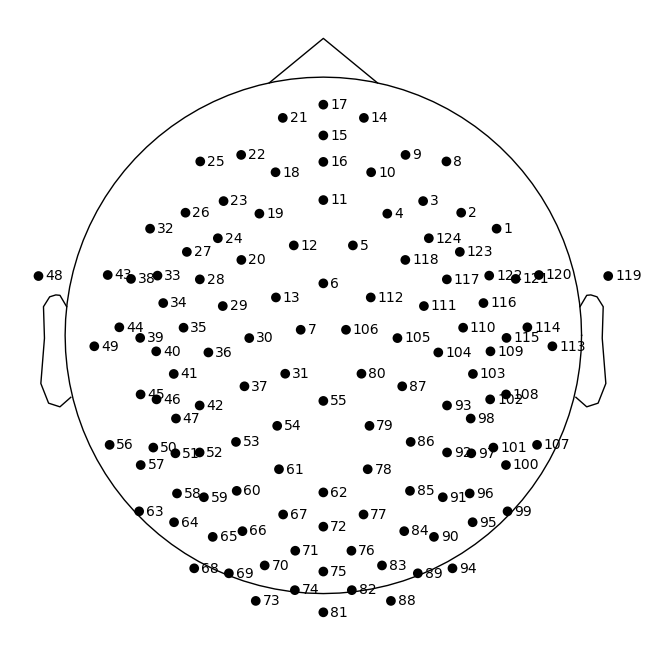

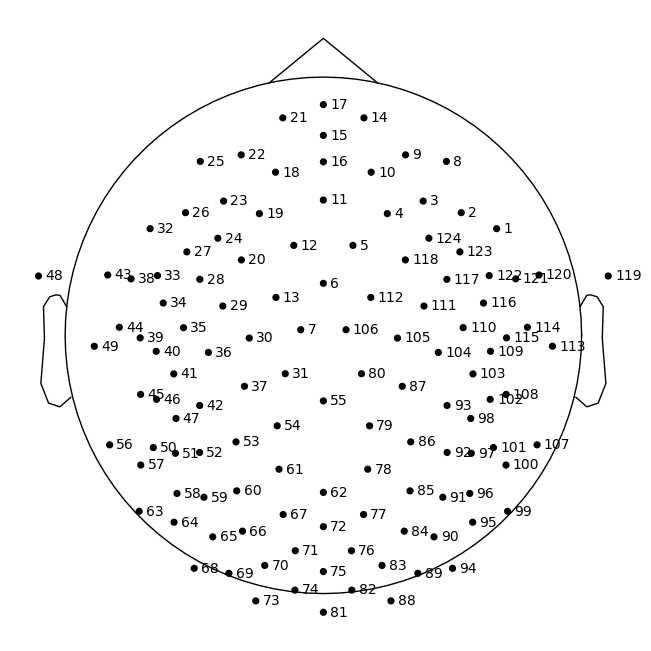

In [309]:
# make custom montage from EGI 128 template and drop electrodes
# 125-130 for consistency with preprocessing pipeline

montage = mne.channels.read_custom_montage('/Users/ethanroy/Downloads/2_9AverageNet128_v1.sfp') # Or use your existing montage

# reset channel names
montage.ch_names = [str(ch) for ch in list(range(0,130))]

# Define the channels to remove
channels_to_remove = [str(ch) for ch in list(range(125,130))]

# Create a new list of dig_points *and* corresponding ch_names
# This ensures that both lists are always in sync
filtered_eeg_dig_points = []
filtered_eeg_ch_names = []
fiducial_dig_points = []

for i, dp in enumerate(montage.dig):
    # Assuming 'ident' within dp.items().mapping holds the channel name/identifier
    ch_name_from_dig = str(dp.items().mapping['ident'])
    
    if dp['kind'] == FIFF.FIFFV_POINT_EEG: # Check if it's an EEG point
        if ch_name_from_dig not in channels_to_remove:
            filtered_eeg_dig_points.append(dp)
            filtered_eeg_ch_names.append(ch_name_from_dig)
            
    elif dp['kind'] in (FIFF.FIFFV_POINT_LPA, FIFF.FIFFV_POINT_NASION, FIFF.FIFFV_POINT_RPA):
        # Keep fiducials if needed, but don't include their names in ch_names for DigMontage
        fiducial_dig_points.append(dp)
    # You might want to handle other point types (e.g., FIFFV_POINT_HPI, FIFFV_POINT_EXTRA) if present

# Combine the filtered EEG points and the fiducial points for the new DigMontage
# The 'dig' argument can contain both, but 'ch_names' should only be for EEG
all_filtered_dig_points = fiducial_dig_points + filtered_eeg_dig_points

# Create a new DigMontage from the filtered data
filtered_montage = mne.channels.DigMontage(dig=all_filtered_dig_points, ch_names=filtered_eeg_ch_names)

# assign new montage as our info.montage
info.set_montage(filtered_montage, match_case=False)

filtered_montage.plot()


In [317]:
info['sfreq']

200.0

In [582]:
def make_epochs(dataset, info, cat, event_dict, n_trials, idx_filt):
    """
    Create an MNE EpochsArray from preprocessed dataset trials.
    
    Takes a preprocessed dataset and converts trials of a specified category
    into an MNE EpochsArray object for further analysis.
    
    Parameters
    ----------
    dataset : dict
        Preprocessed dataset containing:
        - 'X_3d': 3D array of EEG data with shape (channels, timepoints, trials)
        - Category data (e.g., 'labels_correct') with trial labels
    info: dict
        MNE Info Object
    cat : array-like
        Category extracted from dataset (e.g., dataset['labels_correct']).
        Special handling for 'labels_correct' vs other categories.
    event_dict : dict
        Mapping of event names to event codes for MNE compatibility.
    n_trials : int
        Total number of trials in the dataset.
    idx_filt : array-like
        Boolean or integer array for filtering specific trials.
        Not applied when cat='labels_correct'.
    
    Returns
    -------
    mne.EpochsArray
        MNE EpochsArray object with:
        - Baseline correction applied (-150ms to 0ms)
        - Time window starting at -150ms
        - Events and event_id properly formatted
    
    Notes
    -----
    - Assumes 1-second intervals between trial onsets
    - Applies baseline correction from -150ms to stimulus onset (0ms)
    - Transposes data from (channels, timepoints, trials) to 
      (trials, channels, timepoints) for MNE compatibility
    """

    # if cat=='labels_correct':
    events = np.column_stack(
        (
            np.arange(0, int(info['sfreq'])*n_trials,int(info['sfreq'])),
            np.zeros(n_trials, dtype=int),
            cat,
        )
    )

    # else:
    #      events = np.column_stack(
    #         (
    #             np.arange(0, int(info['sfreq'])*n_trials,int(info['sfreq'])),
    #             np.zeros(n_trials, dtype=int),
    #             dataset[cat][idx_filt],
    #         )
    #     )
         
    
    epochs = mne.EpochsArray(data=np.transpose(dataset['X_3d'][:,:,idx_filt], (2, 0, 1)),
                                        info=info, tmin=-0.150, baseline=(-0.150, 0),
                                        events=events, event_id=event_dict)

    return epochs

In [587]:
# load data
root_dir = '/Users/ethanroy/Documents/Stanford/EdNeuro/eeg_groupitizing/data/classification_data'
pilot2_dir = op.join(root_dir, 'pilot2')
synapse_dir = op.join(root_dir, 'synapse_pilot')

subs = ['ENI_032', "ENI_195", "BLC_1043_2"]
subs_dict = {}

num_epoch_list = []
format_epoch_list = []
solution_epoch_list = []

for sub in subs:
    print(f"Loading data for {sub}")
    # Load data for pilot 1
    if 'BLC' in sub:
                subs_dict[sub] = load_data(f'{sub}.mat', synapse_dir)
    else:
        subs_dict[sub] = load_data(f'{sub}.mat', pilot2_dir)

    dataset = subs_dict[sub]

    # set up data for classifier analysis
    # grab just the indices of the operands
    op_idx = np.concat([dataset['op_1_idx'], dataset['op_2_idx']])
    solution_idx = dataset['solution_idx']

    dot_idx = dataset['trial_format']==1
    digit_idx = dataset['trial_format']==2

    dot_idx_op = get_op_idx_by_format(dot_idx)
    digit_idx_op = get_op_idx_by_format(digit_idx)

    num_epoch_list.append(make_epochs(dataset, info, dataset['labels_numerosity'][op_idx], 
                             dict(one=1, two=2, three=3, four=4, five=5), 320, op_idx))
    
    format_epoch_list.append(make_epochs(dataset, info, dataset['labels3'][op_idx], 
                                dict(dots=1, digits=2), 320, op_idx))
    
    solution_epoch_list.append(make_epochs(dataset, info, dataset['labels_correct'], 
                                        dict(correct=1, incorrect=0), 160, solution_idx))




Loading data for ENI_032
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for ENI_195
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for BLC_1043_2
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 proje

combining channels using "mean"
combining channels using "mean"


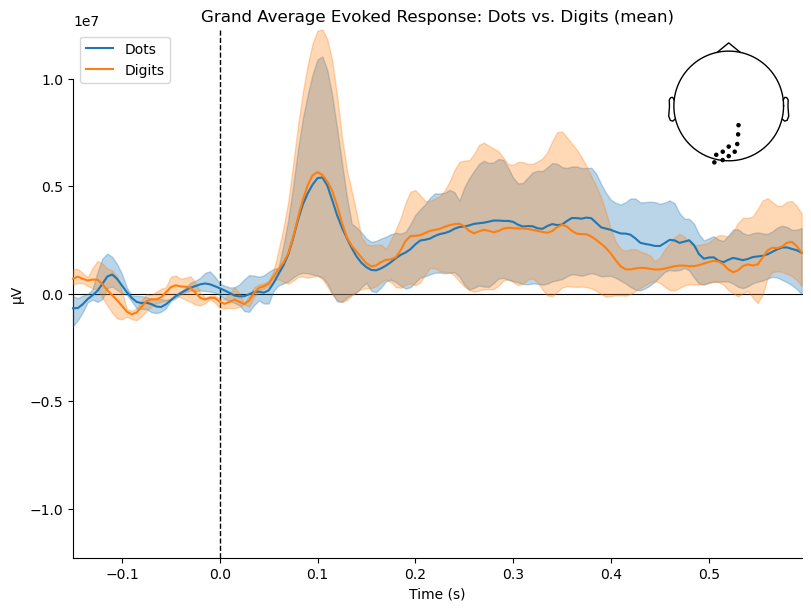

In [588]:
all_evoked_dots = []
all_evoked_digits = []

 # Average epochs for 'dots' and 'digits' conditions
for epoch in solution_epoch_list:

    evoked_dots = epoch['correct'].average()
    evoked_digits = epoch['incorrect'].average()
    
    # Add the individual evoked responses to the lists
    all_evoked_dots.append(evoked_dots)
    all_evoked_digits.append(evoked_digits)


conditions_for_plotting_with_ci = {
    'Dots': all_evoked_dots,
    'Digits': all_evoked_digits
}

# # Compute the grand average evoked responses for each condition
# grand_average_dots = mne.grand_average(all_evoked_dots)
# grand_average_digits = mne.grand_average(all_evoked_digits)

# # Plot the grand average evoked responses for comparison
# # Using a dictionary for better labeling in the plot
# conditions_to_plot = {'Dots': grand_average_dots, 'Digits': grand_average_digits}

fig = mne.viz.plot_compare_evokeds(conditions_for_plotting_with_ci, 
                                #    picks=[f'{n}' for n in range(80,90)],  # You might want to pick specific channels or types
                                    picks = [f"{n}" for n in range(70, 80)],  # You might want to pick specific channels or types
                                   combine='mean', # Or 'gfp' or a custom function
                                   show_sensors=True,truncate_xaxis=False,
                                   title='Grand Average Evoked Response: Dots vs. Digits')


In [808]:
def run_LDA(epoch_list, categories, cv=5, plot=True):

    cat_pairs = list(itertools.combinations(categories, 2))
    results = {}

    for pair in cat_pairs:

        results[pair] = dict(coef_list=[], score_list=[])

        for epoch in epoch_list:

            # Parameters
            cross_val = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

            # To collect results
            scores = []
            coefs = []

            X = epoch[[pair[0],pair[1]]].get_data(copy=False)  # EEG signals: n_epochs, n_meg_channels, n_times
            y = epoch[[pair[0],pair[1]]].events[:, 2]  # target: auditory left vs visual left

            for train_idx, test_idx in cross_val.split(X, y):

                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                clf = make_pipeline(
                    StandardScaler(),
                    PCA(n_components=0.99),
                    LinearModel(LogisticRegression(solver="lbfgs"))
                )

                time_decod = SlidingEstimator(clf, n_jobs=None, scoring="accuracy", verbose=True)
                time_decod.fit(X_train, y_train)

                coefs.append(get_coef(time_decod, "patterns_", inverse_transform=True))
                scores.append(time_decod.score(X_test, y_test))

            mean_coef = np.array(coefs).mean(axis=0)
            mean_scores = np.array(scores).mean(axis=0)

            results[pair]['coef_list'].append(mean_coef)
            results[pair]['score_list'].append(mean_scores)


        # return mean_coef, coef_list
        if plot:

            plot_coef = np.array(results[pair]['coef_list']).mean(axis=0)

            evoked_time_gen = mne.EvokedArray(mean_coef, epoch_list[0][categories].info, 
                                            tmin=epoch_list[0][categories].times[0])
            joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))

            # evoked_time_gen.plot_topomap(times=times, ch_type='eeg')

            evoked_time_gen.plot_joint(
                times=np.arange(0.0, 0.500, 0.100), title=f"{pair[0]} vs. {pair[1]}", **joint_kwargs
            )

        return results
    

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


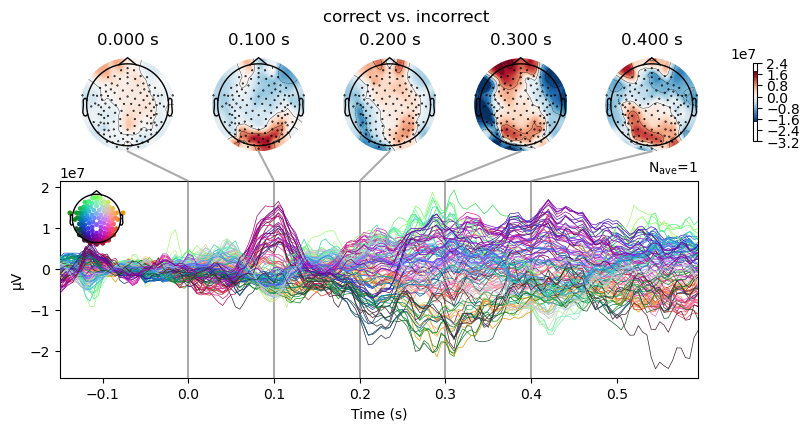

In [809]:
corr_res = run_LDA(solution_epoch_list,['correct','incorrect'],cv=3)

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


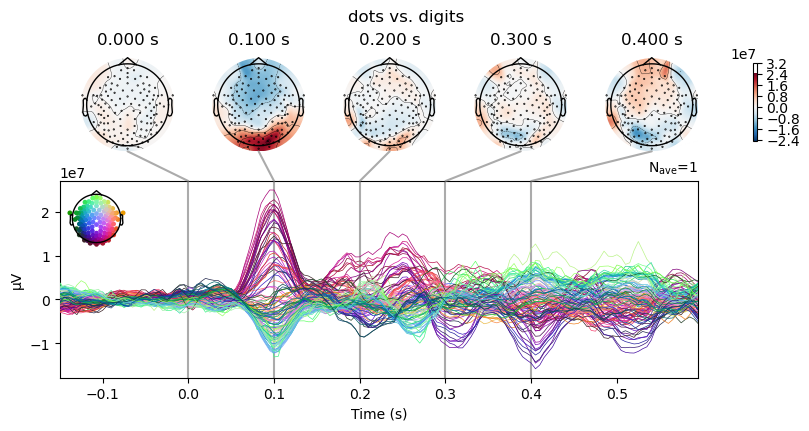

In [738]:
format_res = run_LDA(format_epoch_list,['dots','digits'])

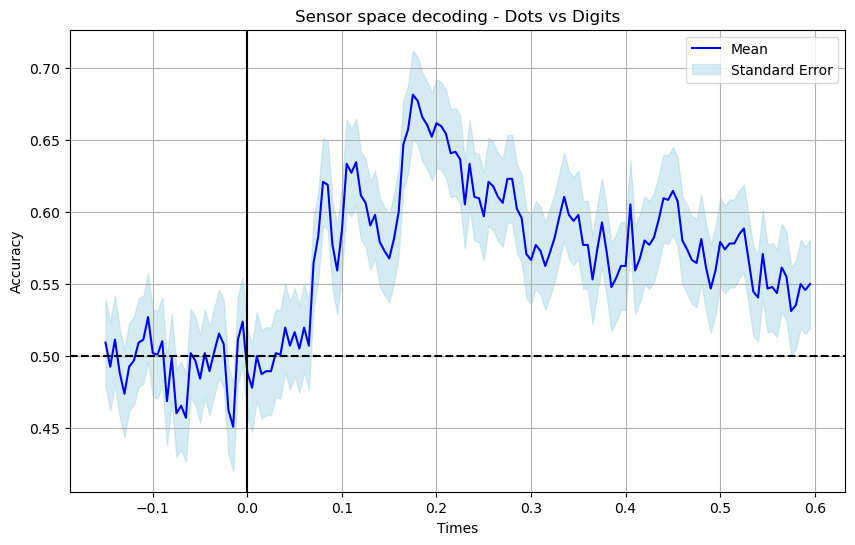

In [756]:
# 2. Calculate the mean and standard error

scores = np.array(format_res[('dots','digits')]['score_list']).mean(axis=0)
mean_data = np.array(scores).mean(axis=0)
std_error = np.std(scores, axis=0) / np.sqrt(len(format_res[('dots','digits')]['score_list'])) # Standard error of the mean

# 3. Plot the mean line and the standard error ribbon
plt.figure(figsize=(10, 6))
plt.plot(format_epoch_list[0].times, scores, label='Mean', color='blue')
plt.fill_between(format_epoch_list[0].times, scores - std_error, scores + std_error, color='lightblue', alpha=0.5, label='Standard Error')

# 4. Add labels, title, and legend for clarity

plt.legend()
plt.grid(True)
plt.xlabel("Times")
plt.ylabel("Accuracy")  # Area Under the Curve
plt.legend()
plt.axvline(0.0, color="k", linestyle="-")
plt.axhline(0.5, color="k", linestyle="--", label="chance")
plt.title("Sensor space decoding - Dots vs Digits")
plt.show()

In [ ]:
shap_list = []

for epoch in format_epoch_list:


    clf = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
    ])

    X = epoch.get_data(copy=False)  # EEG signals: n_epochs, n_meg_channels, n_times
    y = epoch.events[:, 2]  # target: auditory left vs visual left

    time_decod = SlidingEstimator(clf, n_jobs=None, scoring="accuracy", verbose=True)
    time_decod.fit(X, y-1)

    shap_list.append(get_shap_values(time_decod, X))

mean_shap = np.array(shap_list).mean(axis=0)


)

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  Extracting SHAP values from SlidingEstimator.


  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  Extracting SHAP values from SlidingEstimator.


  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  Extracting SHAP values from SlidingEstimator.


ValueError: Data must be a 2D array of shape (n_channels, n_samples), got shape (3, 124, 150)

No projector specified for this dataset. Please consider the method self.add_proj.


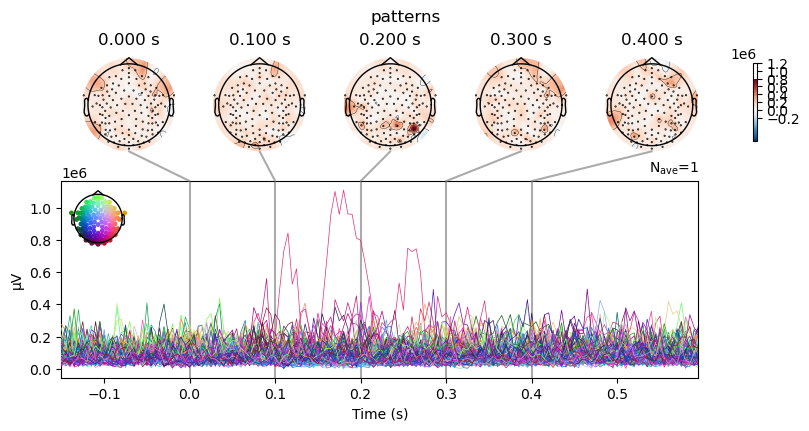

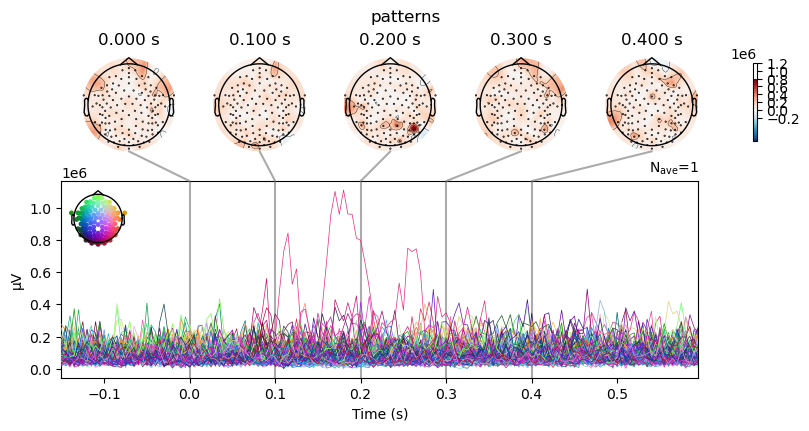

In [231]:
evoked_time_gen = mne.EvokedArray(mean_shap, format_epoch_list[0][['dots','digits']].info, 
                                  tmin=format_epoch_list[0][['dots','digits']].times[0])
joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))

# evoked_time_gen.plot_topomap(times=times, ch_type='eeg')

evoked_time_gen.plot_joint(
    times=np.arange(0.0, 0.500, 0.100), title="patterns", **joint_kwargs
)

## Decode Format Within Each Numerosity 

In [781]:
res_list = {}
for i in range(1,6):

    num_format_epoch_list = []

    for sub in subs_dict:

        dataset = subs_dict[sub]
        num_idx = dataset['labels_numerosity']==i
        n_trials = int(sum(num_idx))
        
        num_format_epoch_list.append(make_epochs(dataset, info, dataset['labels3'][num_idx],
                                                dict(dots=1, digits=2), n_trials,
                                                num_idx))

    print(f'{i}: dots vs digits')
    res_list[i] = run_LDA(num_format_epoch_list,['dots','digits'], plot=False)

Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
1: dots vs digits


  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
2: dots vs digits


  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
3: dots vs digits


  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
4: dots vs digits


  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
5: dots vs digits


  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/150 [00:00<?,       ?it/s]

In [804]:
# Grab the average coefficients across each participant and number

coef_list = []

for key in res_list.keys():

    coef_list.append(np.array(res_list[1][('dots','digits')]['coef_list']).mean(axis=0))


In [850]:
# Loop through and calculate the average score across all numbers for each participant

n = len(res_list[1][('dots','digits')]['score_list'])
accumulators = [[] for _ in range(n)]

# Accumulate score lists for each person
for item in res_list.values():
    scores = item[('dots', 'digits')]["score_list"]
    for i in range(n):
        accumulators[i].append(scores[i])  # Append list of scores

# Compute average across all numbers for each person
average_scores = [np.mean(person_scores, axis=0).tolist() for person_scores in accumulators]


No projector specified for this dataset. Please consider the method self.add_proj.


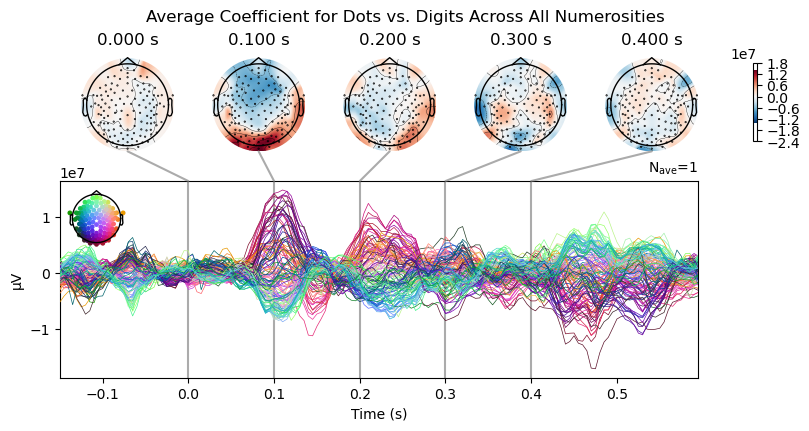

In [806]:

mean_coef = np.array(coef_list).mean(axis=0)


evoked_time_gen = mne.EvokedArray(mean_coef, num_format_epoch_list[0][['dots','digits']].info, 
                                tmin=num_format_epoch_list[0][['dots','digits']].times[0])
joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))

# evoked_time_gen.plot_topomap(times=times, ch_type='eeg')

plot = evoked_time_gen.plot_joint(
    times=np.arange(0.0, 0.500, 0.10), title=f"Average Coefficient for Dots vs. Digits Across All Numerosities", **joint_kwargs
)

In [979]:
accuracies = np.array(average_scores)-.5

T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(accuracies, tail=1)

Using a threshold of 2.919986
stat_fun(H1): min=-1.4594076206442481 max=58.453219012716474
Running initial clustering …
Found 12 clusters


  0%|          | Permuting (exact test) : 0/7 [00:00<?,       ?it/s]

In [980]:
clusters

[(array([3]),),
 (array([21]),),
 (array([40, 41, 42]),),
 (array([44, 45, 46, 47, 48, 49, 50, 51]),),
 (array([68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),),
 (array([ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
          94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105]),),
 (array([107, 108, 109]),),
 (array([111, 112]),),
 (array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
         128]),),
 (array([130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140]),),
 (array([142]),),
 (array([146, 147]),)]

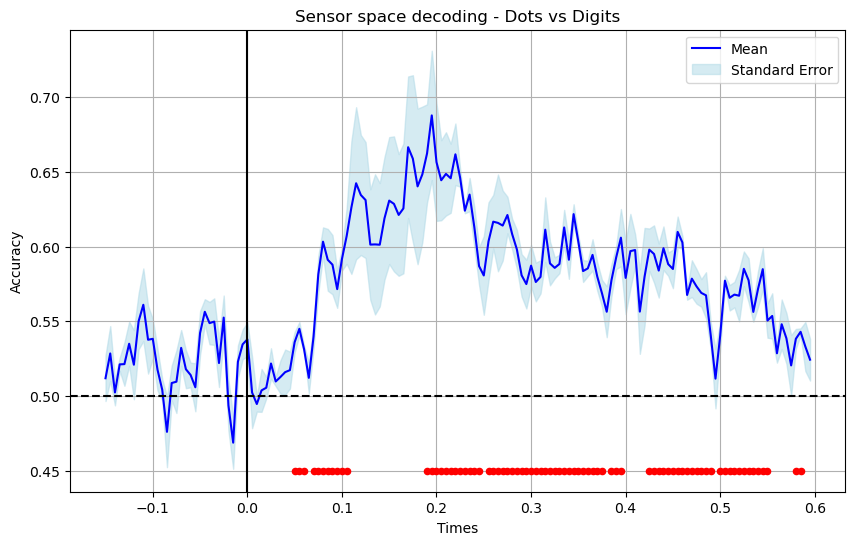

In [924]:
scores = np.array(average_scores).mean(axis=0)
mean_data = np.array(average_scores).mean(axis=0)
std_error = np.std(average_scores, axis=0) / np.sqrt(len(format_res[('dots','digits')]['score_list'])) # Standard error of the mean

# 3. Plot the mean line and the standard error ribbon
plt.figure(figsize=(10, 6))
plt.plot(format_epoch_list[0].times, scores, label='Mean', color='blue')
plt.fill_between(format_epoch_list[0].times, scores - std_error, scores + std_error, color='lightblue', alpha=0.5, label='Standard Error')

# 4. Add labels, title, and legend for clarity

plt.legend()
plt.grid(True)
plt.xlabel("Times")
plt.ylabel("Accuracy")  # Area Under the Curve
plt.legend()
plt.axvline(0.0, color="k", linestyle="-")
plt.axhline(0.5, color="k", linestyle="--", label="chance")
plt.title("Sensor space decoding - Dots vs Digits")

# Make empty mask
significant_mask = np.zeros(scores.shape, dtype=bool)

for i_c, p_val in enumerate(cluster_p_values):
    if p_val < 0.3:
        # cluster[i_c] is a tuple of indices, e.g. (array([23, 24, 25]),)
        cluster_inds = clusters[i_c][0]  # get the time indices
        significant_mask[cluster_inds] = True

# Plot red dots above the error bar
sig_times = format_epoch_list[0].times[significant_mask]
sig_y = (scores + std_error)[significant_mask] + 0.005
plt.scatter(sig_times, np.ones(sig_times.shape[0])*0.45, color='red', s=20, label='Significant', zorder=5)

### Test Generalization

In [811]:
res_list_num_format_gen = {}

for sub in subs_dict:

    res_list_num_format_gen[sub] = {}

    for i in range(1,6):

        dataset = subs_dict[sub]
        num_idx = dataset['labels_numerosity']==i
        n_trials = int(sum(num_idx))
        
        epoch = make_epochs(dataset, info, dataset['labels3'][num_idx],
                            dict(dots=1, digits=2), n_trials, num_idx)

        print(f'{i}: dots vs digits')
        clf = make_pipeline(
            StandardScaler(),
            PCA(n_components=0.99),
            #  LinearModel(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
            LinearDiscriminantAnalysis(solver="lsqr")
        )
        time_gen_corr = GeneralizingEstimator(clf, scoring="accuracy", n_jobs=4, verbose=True)
        time_gen_corr.fit(X=epoch.get_data(copy=False) , y=epoch.events[:, 2])

        res_list_num_format_gen[sub][i] = time_gen_corr.score(
            X=epoch.get_data(copy=False), y=epoch.events[:, 2]
        )

Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
1: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
2: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
3: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
4: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
5: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
1: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
2: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
3: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
4: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
5: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
1: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
2: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
3: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
4: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
5: dots vs digits


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

In [818]:
full_res = []

for sub in res_list_num_format_gen.keys():

    sub_res = []
    for num in res_list_num_format_gen[sub].keys():
        sub_res.append(res_list_num_format_gen[sub][num])

    full_res.append(np.mean(np.array(sub_res),axis=0))


In [962]:
## Figure out cluster-based permutation testing on 2-d data

accuracies = np.array(full_res)-.5

T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(accuracies, tail=1, n_permutations=2000)

Using a threshold of 2.919986
stat_fun(H1): min=-59.1687310547971 max=535.5552601841737
Running initial clustering …
Found 275 clusters


  0%|          | Permuting (exact test) : 0/7 [00:00<?,       ?it/s]

In [978]:
clusters[0]

(array([  0,   0,   0, ..., 149, 149, 149], shape=(14052,)),
 array([  0,   1,   2, ..., 147, 148, 149], shape=(14052,)))

In [965]:
# scores.shape should be (n_subjects, n_times)
significant_mask = np.zeros(T_obs.shape, dtype=bool)

for i_c, p_val in enumerate(cluster_p_values):
    if p_val < 0.3:
        idx0, idx1 = clusters[i_c]  # unpack the tuple
        significant_mask[idx0, idx1] = True

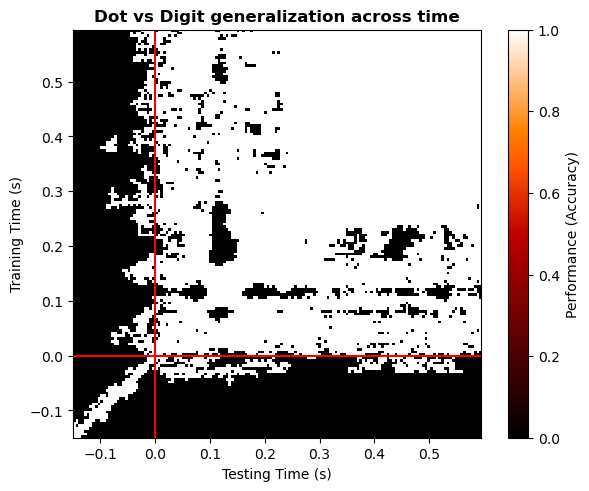

In [966]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    significant_mask,
    vmin=0,
    vmax=1,
    cmap="gist_heat",
    origin="lower",
    extent=format_epoch_list[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Dot vs Digit generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

In [974]:
mean_scores_corr[np.array(significant_mask)].reshape(150,150)

ValueError: cannot reshape array of size 14120 into shape (150,150)

TypeError: Invalid shape (14120,) for image data

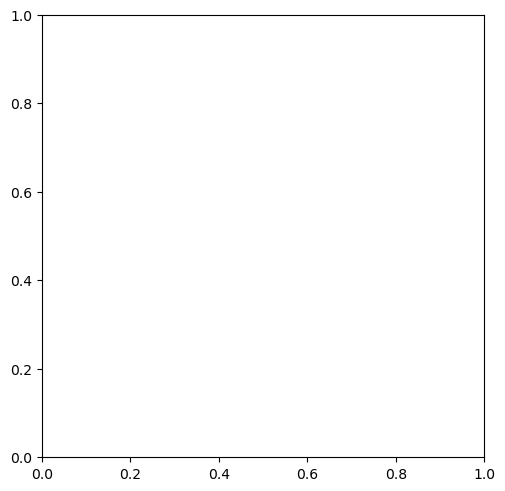

In [967]:
mean_scores_corr = np.mean(np.array(full_res),axis=0)

# mean_scores_corr = full_res[1]

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_scores_corr[significant_mask],
    vmin=0.5,
    vmax=1,
    cmap="gist_heat",
    origin="lower",
    extent=format_epoch_list[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Dot vs Digit generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

## Decode Each Correct/Incorrect and Test Generalization 

In [ ]:

corr_scores = []


for i, epoch in enumerate(solution_epoch_list):

    print(f"Decoding Analysis for: {list(subs_dict.keys())[i]}")


    print('decode correct/inforrect')
    clf = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.99),
        #  LinearModel(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
        LinearDiscriminantAnalysis(solver="lsqr")
    )
    time_gen_corr = GeneralizingEstimator(clf, scoring="accuracy", n_jobs=4, verbose=True)
    time_gen_corr.fit(X=epoch.get_data(copy=False) , y=epoch.events[:, 2])

    corr_scores.append(time_gen_corr.score(
        X=epoch.get_data(copy=False), y=epoch.events[:, 2]
    ))


Decoding Analysis for: ENI_032
decode correct/inforrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Decoding Analysis for: ENI_195
decode correct/inforrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Decoding Analysis for: BLC_1043_2
decode correct/inforrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

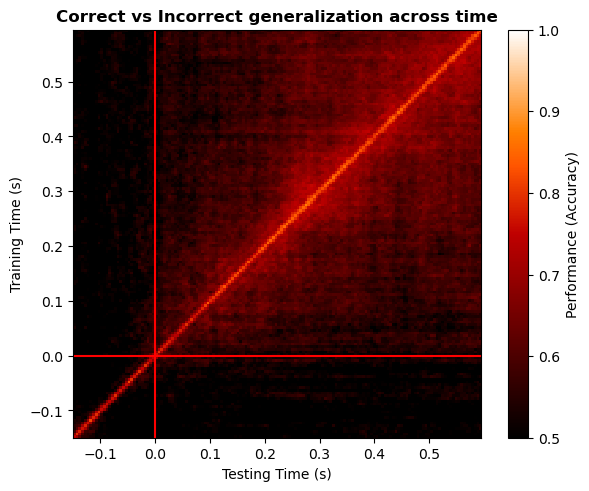

In [ ]:
mean_scores_corr = np.mean(np.array(corr_scores),axis=0)

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_scores_corr,
    vmin=0.5,
    vmax=1.0,
    cmap="gist_heat",
    origin="lower",
    extent=format_epoch_list[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Correct vs Incorrect generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

### Decode Correct/Incorrect Within Each Format and Test Generalization

In [592]:
dataset['labels_correct'][dataset['trial_format']==1]

array([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0])

In [593]:
dot_solution_idx = dataset['solution_idx'][dataset['trial_format']==1]
n_trials_dots = len(dot_solution_idx)

dot_epochs = make_epochs(dataset, info, dataset['labels_correct'][dataset['trial_format']==1],
                            dict(correct=1, incorrect=0), 
                            n_trials_dots, dot_solution_idx)

Not setting metadata


80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [607]:
coef_list = []
form_dict = dict(correct=1, incorrect=0)
sub_res = {}

train_dots_test_dots_scores = []
train_dots_test_digits_scores = []
train_digits_test_digits_scores = []
train_digits_test_dots_scores = []

for sub in subs_dict:

    print(f"Decoding Analysis for: {sub}")

    dataset = subs_dict[sub]

    # make dot epochs
    dot_solution_idx = dataset['solution_idx'][dataset['trial_format']==1]
    n_trials_dots = len(dot_solution_idx)
    
    dot_epochs = make_epochs(dataset, info, dataset['labels_correct'][dataset['trial_format']==1],
                            dict(correct=1, incorrect=0), 
                            n_trials_dots, dot_solution_idx)
    
    # make digit epochs
    digit_solution_idx = dataset['solution_idx'][dataset['trial_format']==2]
    n_trials_digits = len(digit_solution_idx)

    digit_epochs = make_epochs(dataset, info, dataset['labels_correct'][dataset['trial_format']==2],
                            dict(correct=1, incorrect=0), 
                            n_trials_digits, digit_solution_idx)

    print('Dots: decode correct/incorrect')
    clf_dots = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.99),
         LinearModel(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
        # OneVsOneClassifier(LinearDiscriminantAnalysis(solver="lsqr"))
    )
    time_gen_dots = GeneralizingEstimator(clf_dots, scoring="accuracy", n_jobs=4, verbose=True)
    time_gen_dots.fit(X=dot_epochs.get_data(copy=False) , y=dot_epochs.events[:, 2])

    train_dots_test_dots = time_gen_dots.score(
        X=dot_epochs.get_data(copy=False), y=dot_epochs.events[:, 2]
    )

    train_dots_test_dots_scores.append(train_dots_test_dots) 

    train_dots_test_digits = time_gen_dots.score(
        X=digit_epochs.get_data(copy=False), y=digit_epochs.events[:, 2]
    )

    train_dots_test_digits_scores.append(train_dots_test_digits)

    print('Digits: decode correct/incorrect')
    clf_digits = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.99),
         LinearModel(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
        # OneVsOneClassifier(LinearDiscriminantAnalysis(solver="lsqr"))
    )
    time_gen_digits = GeneralizingEstimator(clf_digits, scoring="accuracy", n_jobs=4, verbose=True)
    time_gen_digits.fit(X=digit_epochs.get_data(copy=False) , y=digit_epochs.events[:, 2])


    train_digits_test_digits = time_gen_digits.score(
        X=digit_epochs.get_data(copy=False), y=digit_epochs.events[:, 2]
    )

    train_digits_test_digits_scores.append(train_digits_test_digits)

    train_digits_test_dots = time_gen_digits.score(
        X=dot_epochs.get_data(copy=False), y=dot_epochs.events[:, 2]
    )
    train_digits_test_dots_scores.append(train_digits_test_dots)

    sub_res[sub] = {'dot_mod': time_gen_dots,
                    'digit_mod': time_gen_digits,
                    'train_digits': {"dot_score":train_digits_test_dots, "digit_score": train_digits_test_digits},
                    'train_dots': {"dot_score":train_dots_test_dots, "digit_score": train_dots_test_digits}

                    }

Decoding Analysis for: ENI_032
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Dots: decode correct/incorrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Digits: decode correct/incorrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Decoding Analysis for: ENI_195
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Dots: decode correct/incorrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Digits: decode correct/incorrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Decoding Analysis for: BLC_1043_2
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Dots: decode correct/incorrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Digits: decode correct/incorrect


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

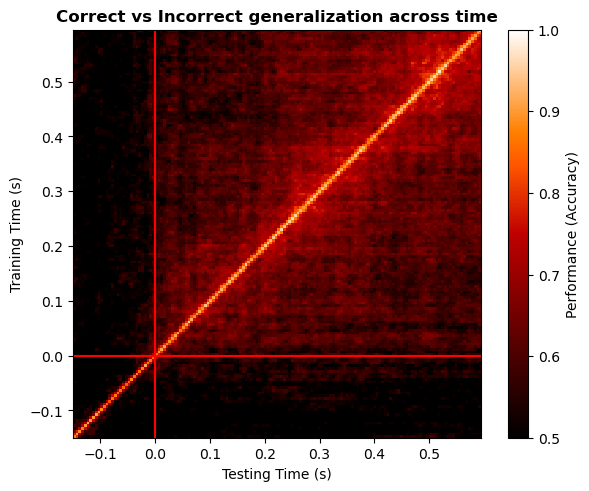

In [608]:
mean_score_dots_dots = np.array(train_dots_test_dots_scores).mean(axis=0)

# mean_score_dots_dots = sub_res['ENI_195']['train_dots']['dot_score']

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_score_dots_dots,
    vmin=0.5,
    vmax=1.0,
    cmap="gist_heat",
    origin="lower",
    extent=dot_epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Correct vs Incorrect generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

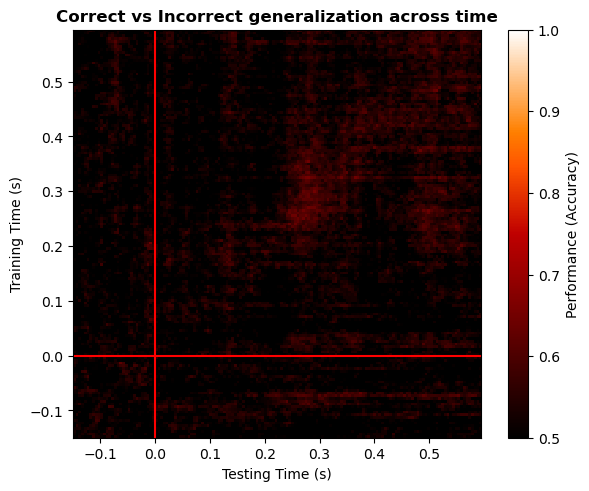

In [609]:
mean_score_dots_digits = np.array(train_dots_test_digits_scores).mean(axis=0)

# mean_score_dots_dots = sub_res['ENI_195']['train_dots']['dot_score']

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_score_dots_digits,
    vmin=0.5,
    vmax=1.0,
    cmap="gist_heat",
    origin="lower",
    extent=dot_epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Correct vs Incorrect generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

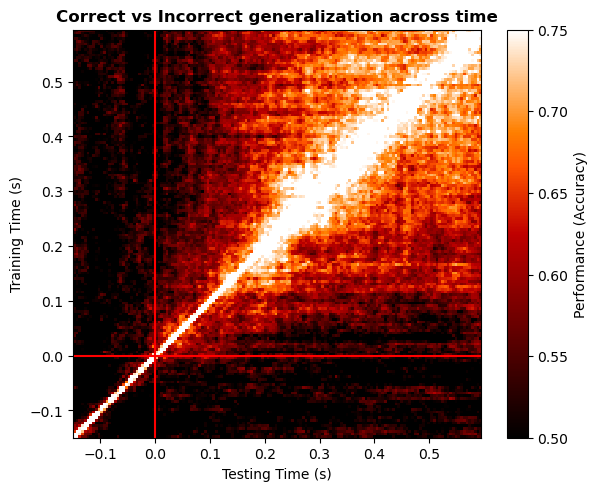

In [615]:
mean_score_digits_digits = np.array(train_digits_test_digits_scores).mean(axis=0)

# mean_score_dots_dots = sub_res['ENI_195']['train_dots']['dot_score']

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_score_digits_digits,
    vmin=0.5,
    vmax=0.75,
    cmap="gist_heat",
    origin="lower",
    extent=dot_epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Correct vs Incorrect generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

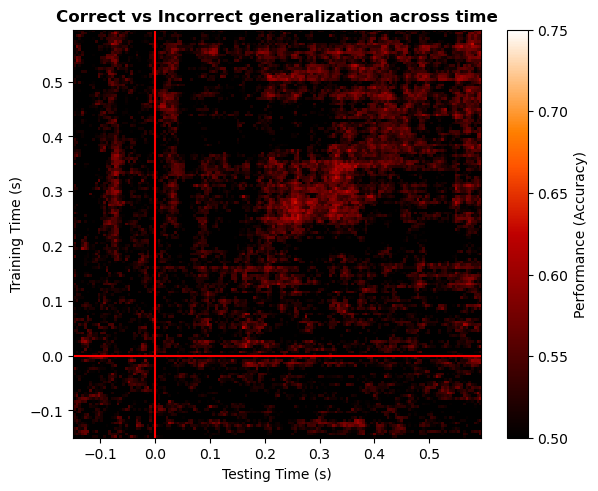

In [614]:
mean_score_digits_dots = np.array(train_digits_test_dots_scores).mean(axis=0)

# mean_score_dots_dots = sub_res['ENI_195']['train_dots']['dot_score']

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_score_digits_dots,
    vmin=0.5,
    vmax=0.75,
    cmap="gist_heat",
    origin="lower",
    extent=dot_epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Correct vs Incorrect generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

mean_score_dots_digits = np.array(train_dots_test_digits_scores).mean(axis=0)



## Decode Each Format and Test Generalization 

In [567]:
coef_list = []
form_dict = dict(dots=1, digits=2)
sub_res = {}

format_scores = []


for i, epoch in enumerate(format_epoch_list):

    print(f"Decoding Analysis for: {list(subs_dict.keys())[i]}")


    print('Dots: decode numerosity')
    clf = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.99),
        #  LinearModel(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
        LinearDiscriminantAnalysis(solver="lsqr")
    )
    time_gen_dots = GeneralizingEstimator(clf, scoring="accuracy", n_jobs=4, verbose=True)
    time_gen_dots.fit(X=epoch.get_data(copy=False) , y=epoch.events[:, 2])

    format_scores.append(time_gen_dots.score(
        X=epoch.get_data(copy=False), y=epoch.events[:, 2]
    ))


Decoding Analysis for: ENI_032
Dots: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Decoding Analysis for: ENI_195
Dots: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Decoding Analysis for: BLC_1043_2
Dots: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

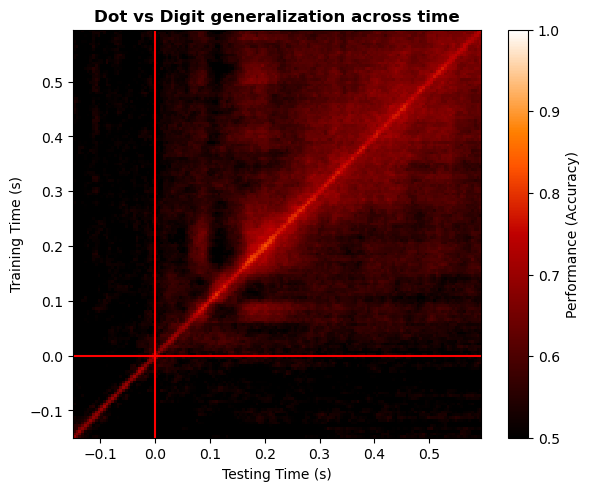

In [617]:
mean_scores_form = np.mean(np.array(format_scores),axis=0)

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_scores_form,
    vmin=0.5,
    vmax=1,
    cmap="gist_heat",
    origin="lower",
    extent=format_epoch_list[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Dot vs Digit generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

### Decode Numerosity Within Each Format and Test Generalization 

In [619]:
coef_list = []
form_dict = dict(dots=1, digits=2)
sub_res = {}

train_dots_test_dots_scores = []
train_dots_test_digits_scores = []
train_digits_test_digits_scores = []
train_digits_test_dots_scores = []

for sub in subs_dict:

    print(f"Decoding Analysis for: {sub}")

    dataset = subs_dict[sub]

    n_trials_dots = int(sum(dataset['labels3']==form_dict['dots']))
    
    dot_epochs = make_epochs(dataset, info, dataset['labels_numerosity'][(dataset['labels3']==form_dict['dots'])], 
                            dict(one=1, two=2, three=3, four=4, five=5),
                            n_trials_dots, (dataset['labels3']==form_dict['dots']))
    
    n_trials_digits = int(sum((dataset['labels3']==2)&(dataset['labels_numerosity']<=5)))
    digit_epochs = make_epochs(dataset, info, 
                               dataset['labels_numerosity'][(dataset['labels3']==2)&(dataset['labels_numerosity']<=5)], 
                            dict(one=1, two=2, three=3, four=4, five=5),
                            n_trials_digits, ((dataset['labels3']==2)&(dataset['labels_numerosity']<=5)))

    print('Dots: decode numerosity')
    clf_dots = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.99),
         OneVsOneClassifier(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
        # OneVsOneClassifier(LinearDiscriminantAnalysis(solver="lsqr"))
    )
    time_gen_dots = GeneralizingEstimator(clf_dots, scoring="accuracy", n_jobs=4, verbose=True)
    time_gen_dots.fit(X=dot_epochs.get_data(copy=False) , y=dot_epochs.events[:, 2])

    train_dots_test_dots = time_gen_dots.score(
        X=dot_epochs.get_data(copy=False), y=dot_epochs.events[:, 2]
    )

    train_dots_test_dots_scores.append(train_dots_test_dots) 

    train_dots_test_digits = time_gen_dots.score(
        X=digit_epochs.get_data(copy=False), y=digit_epochs.events[:, 2]
    )

    train_dots_test_digits_scores.append(train_dots_test_digits)

    print('Digits: decode numerosity')
    clf_digits = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.99),
         OneVsOneClassifier(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
        # OneVsOneClassifier(LinearDiscriminantAnalysis(solver="lsqr"))
    )
    time_gen_digits = GeneralizingEstimator(clf_digits, scoring="accuracy", n_jobs=4, verbose=True)
    time_gen_digits.fit(X=digit_epochs.get_data(copy=False) , y=digit_epochs.events[:, 2])


    train_digits_test_digits = time_gen_digits.score(
        X=digit_epochs.get_data(copy=False), y=digit_epochs.events[:, 2]
    )

    train_digits_test_digits_scores.append(train_digits_test_digits)

    train_digits_test_dots = time_gen_digits.score(
        X=dot_epochs.get_data(copy=False), y=dot_epochs.events[:, 2]
    )
    train_digits_test_dots_scores.append(train_digits_test_dots)

    sub_res[sub] = {'dot_mod': time_gen_dots,
                    'digit_mod': time_gen_digits,
                    'train_digits': {"dot_score":train_digits_test_dots, "digit_score": train_digits_test_digits},
                    'train_dots': {"dot_score":train_dots_test_dots, "digit_score": train_dots_test_digits}

                    }

Decoding Analysis for: ENI_032
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
216 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Dots: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Digits: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Decoding Analysis for: ENI_195
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
216 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Dots: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Digits: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Decoding Analysis for: BLC_1043_2
Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
216 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Dots: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

Digits: decode numerosity


  0%|          | Fitting GeneralizingEstimator : 0/150 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/22500 [00:00<?,       ?it/s]

In [ ]:
eni_195_dots = make_epochs(subs_dict['ENI_195'], info, 'labels_numerosity', 
                            dict(one=1, two=2, three=3, four=4, five=5),
                            n_trials_dots, (dataset['labels3']==form_dict['dots']))

Not setting metadata
160 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [ ]:
eni_195_dots.get_data(copy=False)[:,:,75].shape

# [:,75,(subs_dict['ENI_195']['labels3']==form_dict['dots'])].shape


(160, 124)

In [ ]:
sub_res['ENI_195']['dot_mod'].estimators_[75].score(eni_195_dots.get_data(copy=False)[:,:,75], 
                                                    subs_dict['ENI_195']['labels_numerosity'][(subs_dict['ENI_195']['labels3']==form_dict['dots'])])


0.15

In [ ]:
np.max(sub_res['ENI_195']['train_dots']['dot_score'])

np.float64(0.85)

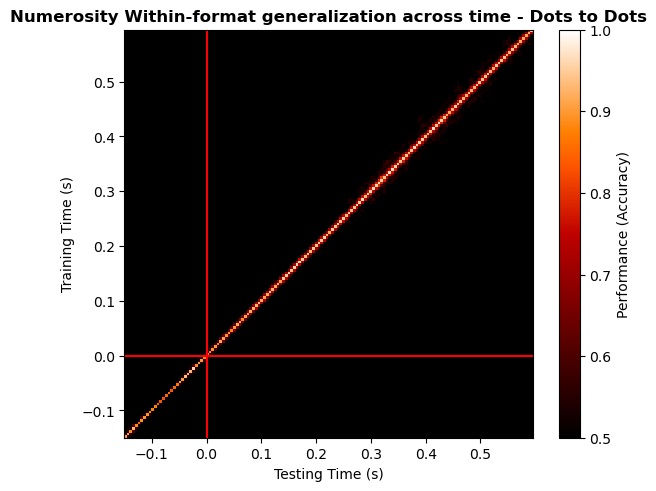

Exception ignored in: <function ResourceTracker.__del__ at 0x108f79c60>
Traceback (most recent call last):
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106bddc60>
Traceback (most recent call last):
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 1

In [630]:
mean_score_dots_dots_num = np.array(train_dots_test_dots_scores).mean(axis=0)

# mean_score_dots_dots = sub_res['ENI_195']['train_dots']['dot_score']

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_score_dots_dots_num,
    vmin=0.5,
    vmax=1,
    cmap="gist_heat",
    origin="lower",
    extent=dot_epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Numerosity Within-format generalization across time - Dots to Dots", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

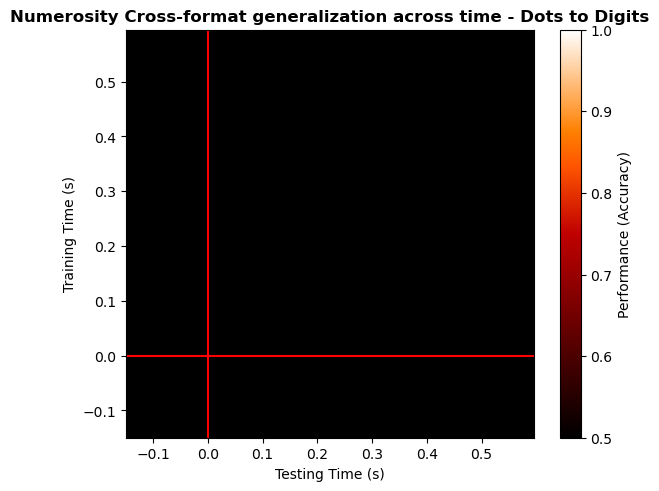

In [627]:
mean_score_dots_digits_num = np.array(train_dots_test_digits_scores).mean(axis=0)

# mean_score_dots_dots = sub_res['ENI_195']['train_dots']['dot_score']

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_score_dots_digits_num,
    vmin=0.5,
    vmax=1,
    cmap="gist_heat",
    origin="lower",
    extent=dot_epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Numerosity Cross-format generalization across time - Dots to Digits", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

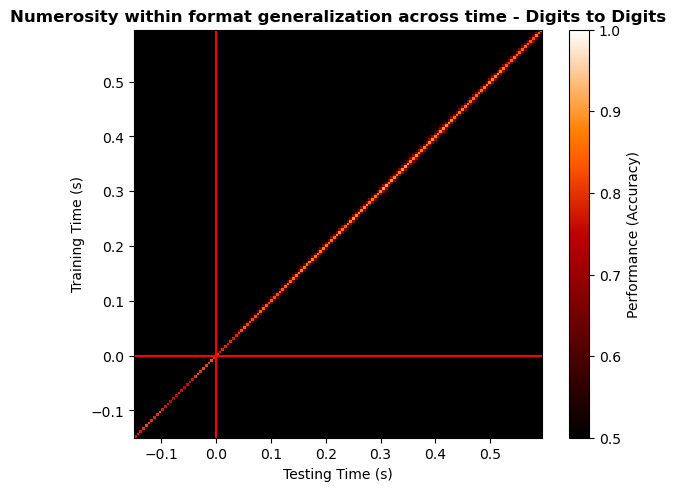

In [628]:
mean_score_digits_digits = np.array(train_digits_test_digits_scores).mean(axis=0)

# mean_score_dots_dots = sub_res['ENI_195']['train_dots']['dot_score']

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_score_digits_digits,
    vmin=0.5,
    vmax=1.0,
    cmap="gist_heat",
    origin="lower",
    extent=dot_epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Numerosity within format generalization across time - Digits to Digits", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

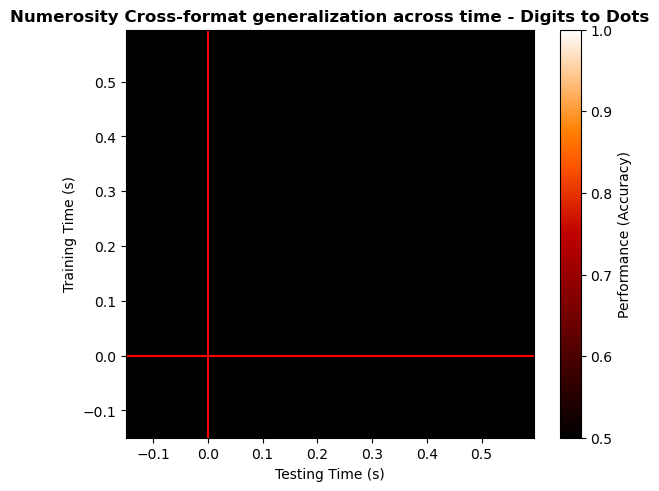

In [629]:
mean_score_digits_dots = np.array(train_digits_test_dots_scores).mean(axis=0)

# mean_score_dots_dots = sub_res['ENI_195']['train_dots']['dot_score']

fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    mean_score_digits_dots,
    vmin=0.5,
    vmax=1.0,
    cmap="gist_heat",
    origin="lower",
    extent=dot_epochs[0].times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Numerosity Cross-format generalization across time - Digits to Dots", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()

## Explore Significance Testing

In [ ]:
clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.99),
    #  LinearModel(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
    OneVsOneClassifier(LinearDiscriminantAnalysis(solver="lbfgs"))
)
time_gen = GeneralizingEstimator(clf, scoring="accuracy", n_jobs=None, verbose=True)

# Fit classifiers on the epochs where the stimulus was presented to the left.
# Note that the experimental condition y indicates auditory or visual
time_gen.fit(X=operand_epochs.get_data(copy=False) , y=operand_epochs.events[:, 2]-1)

In [74]:
chance = np.ones(5)*0.5

p_vals = []

for i in range(0,scores.shape[1]):

    _, pval = wilcoxon(scores[:,i],chance)   

    p_vals += [pval]


p_vals

[np.float64(0.625),
 np.float64(1.0),
 np.float64(0.6875),
 np.float64(0.625),
 np.float64(0.4375),
 np.float64(0.625),
 np.float64(0.75),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.5),
 np.float64(0.5),
 np.float64(0.6875),
 np.float64(0.6875),
 np.float64(0.75),
 np.float64(0.875),
 np.float64(0.625),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.75),
 np.float64(1.0),
 np.float64(0.875),
 np.float64(1.0),
 np.float64(0.75),
 np.float64(0.0625),
 np.float64(0.125),
 np.float64(0.1875),
 np.float64(0.1875),
 np.float64(0.125),
 np.float64(0.0625),
 np.float64(0.5),
 np.float64(0.8125),
 np.float64(0.8125),
 np.float64(0.6875),
 np.float64(0.625),
 np.float64(0.625),
 np.float64(1.0),
 np.float64(0.1875),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.625),
 np.float64(0.5),
 np.float64(0.5),
 np.float64(0.1875),
 np.float64(0.25),
 np.float64(0.125),
 np.float64(0.0625),
 np.float64(0.0625),
 np.float64(0.0625),
 np.float64(0.125),
 np

In [ ]:

clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.99),
    #  LinearModel(LogisticRegression(solver="liblinear")),  # liblinear is faster than lbfgs
    LinearModel(LinearDiscriminantAnalysis(solver="svd"))
)
time_gen = GeneralizingEstimator(clf, scoring="roc_auc", n_jobs=None, verbose=True)

# Fit classifiers on the epochs where the stimulus was presented to the left.
# Note that the experimental condition y indicates auditory or visual
time_gen.fit(X=operand_epochs.get_data(copy=False) , y=operand_epochs.events[:, 2]-1)

  0%|          | Fitting GeneralizingEstimator : 0/375 [00:00<?,       ?it/s]

<GeneralizingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA(n_components=0.99)), ('linearmodel', LinearModel(model=LinearDiscriminantAnalysis()))]), scoring='roc_auc', verbose=True, fitted with 375 estimators, fitted with 375 estimators>

In [77]:
scores = time_gen.score(
    X=operand_epochs.get_data(copy=False), y=operand_epochs.events[:, 2]-1
)

  0%|          | Scoring GeneralizingEstimator : 0/140625 [00:00<?,       ?it/s]

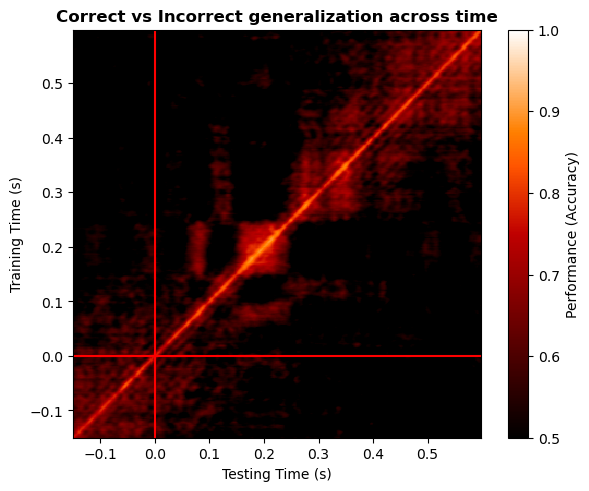

In [78]:
fig, ax = plt.subplots(layout="constrained")
im = ax.matshow(
    scores,
    vmin=0.5,
    vmax=1.0,
    cmap="gist_heat",
    origin="lower",
    extent=operand_epochs.times[[0, -1, 0, -1]],
)
ax.axhline(0.0, color="r")
ax.axvline(0.0, color="r")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel(
    'Testing Time (s)',
)
ax.set_ylabel('Training Time (s)')
ax.set_title("Correct vs Incorrect generalization across time", fontweight="bold")
fig.colorbar(im, ax=ax, label="Performance (Accuracy)")
plt.show()


=== Processing numerosity 1 ===
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Processing dots vs digits
  Participant 1/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   59.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished


  Participant 2/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished


  Participant 3/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished


No projector specified for this dataset. Please consider the method self.add_proj.


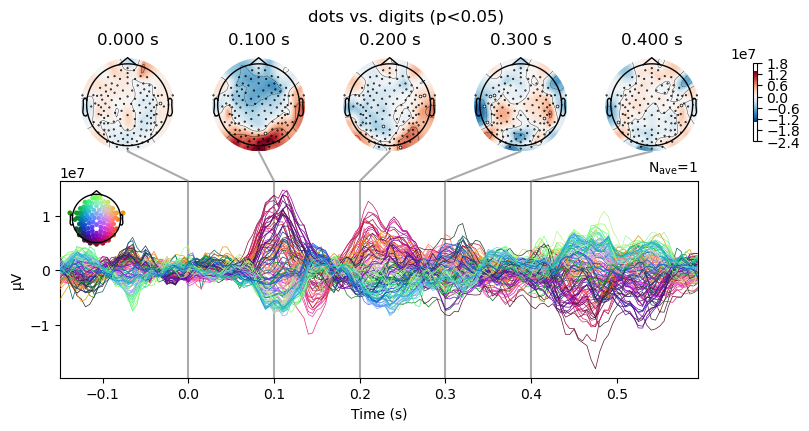

Numerosity 1: Analysis complete

=== Processing numerosity 2 ===
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Processing dots vs digits
  Participant 1/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   51.3s finished


  Participant 2/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   53.2s finished


  Participant 3/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.1s finished


No projector specified for this dataset. Please consider the method self.add_proj.


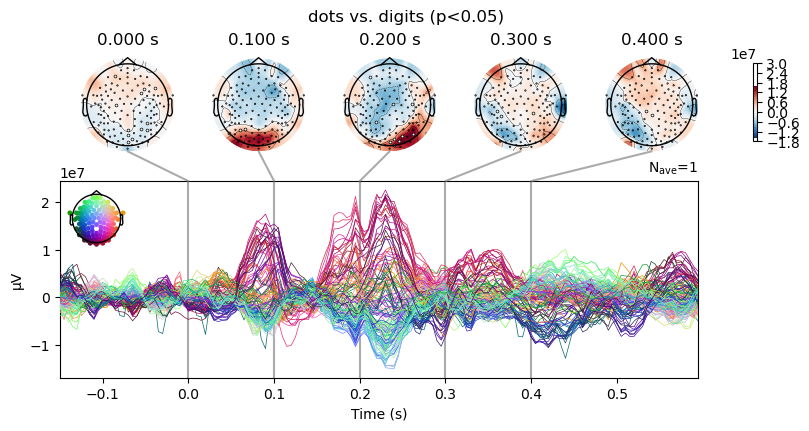

Numerosity 2: Analysis complete

=== Processing numerosity 3 ===
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Processing dots vs digits
  Participant 1/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished


  Participant 2/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  9.1min finished


  Participant 3/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished


No projector specified for this dataset. Please consider the method self.add_proj.


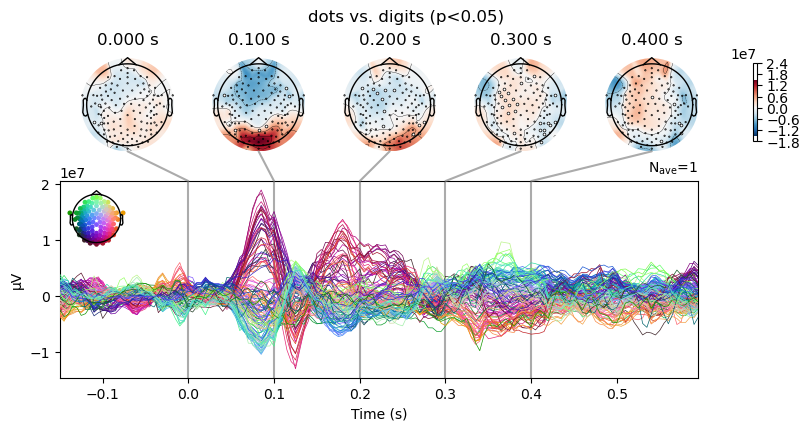

Numerosity 3: Analysis complete

=== Processing numerosity 4 ===
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Processing dots vs digits
  Participant 1/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished


  Participant 2/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.2min finished


  Participant 3/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.2min finished


No projector specified for this dataset. Please consider the method self.add_proj.


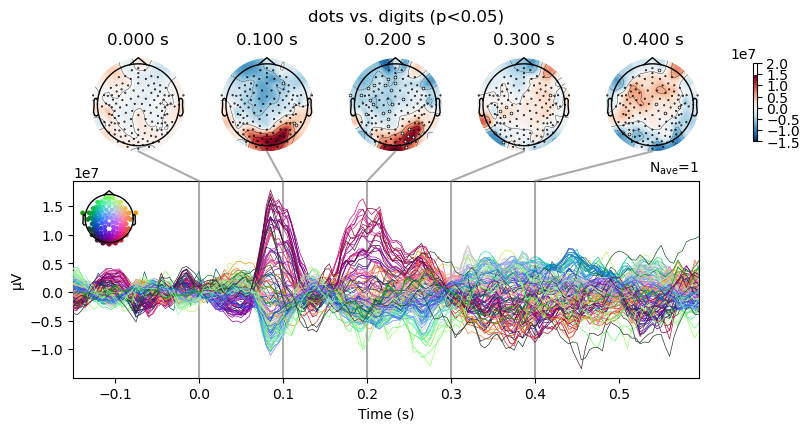

Numerosity 4: Analysis complete

=== Processing numerosity 5 ===
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Processing dots vs digits
  Participant 1/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished


  Participant 2/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished


  Participant 3/3


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished


No projector specified for this dataset. Please consider the method self.add_proj.


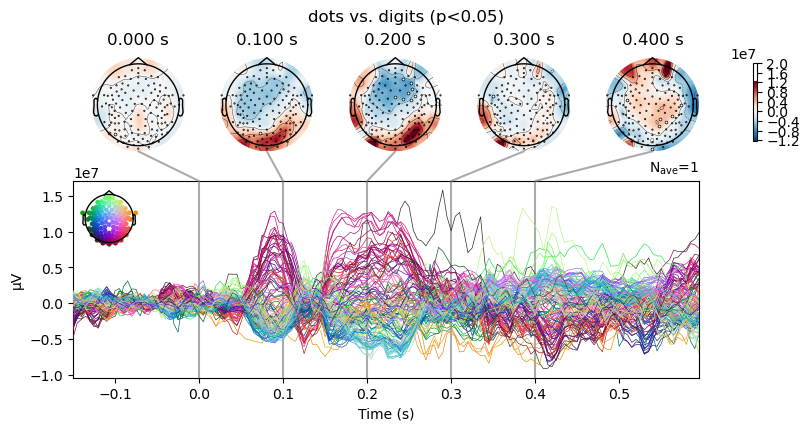

Numerosity 5: Analysis complete


Exception ignored in: <function ResourceTracker.__del__ at 0x1110f1c60>
Traceback (most recent call last):
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106c3dc60>
Traceback (most recent call last):
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/ethanroy/miniconda3/envs/mne/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 1

In [351]:
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np

def run_single_permutation(X, y, perm_idx, random_seed=None):
    """
    Run a single permutation for one participant.
    """
    if random_seed is not None:
        np.random.seed(random_seed + perm_idx)  # Ensure different seeds
    
    y_perm = np.random.permutation(y)
    
    clf_perm = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.99),
        LinearModel(LogisticRegression(solver="lbfgs"))
    )
    
    time_decod_perm = SlidingEstimator(clf_perm, n_jobs=1, scoring="accuracy", verbose=False)
    time_decod_perm.fit(X, y_perm)
    
    return get_coef(time_decod_perm, "patterns_", inverse_transform=True)

def run_LDA_with_parallel_permutations(epoch_list, categories, n_permutations=1000, n_jobs=-1, plot=True):
    """
    Run LDA with parallelized permutation testing.
    """
    cat_pairs = list(itertools.combinations(categories, 2))
    results = {}
    
    for pair in cat_pairs:
        print(f"Processing {pair[0]} vs {pair[1]}")
        
        real_coef_list = []
        perm_coef_list = []
        
        # Process each participant
        for participant_idx, epoch in enumerate(epoch_list):
            print(f"  Participant {participant_idx + 1}/{len(epoch_list)}")
            
            clf = make_pipeline(
                StandardScaler(),
                PCA(n_components=0.99),
                LinearModel(LogisticRegression(solver="lbfgs"))
            )

            X = epoch[[pair[0],pair[1]]].get_data(copy=False)
            y = epoch[[pair[0],pair[1]]].events[:, 2]

            # Real coefficient
            time_decod = SlidingEstimator(clf, n_jobs=1, scoring="accuracy", verbose=False)
            time_decod.fit(X, y)
            real_coef = get_coef(time_decod, "patterns_", inverse_transform=True)
            real_coef_list.append(real_coef)
            
            # Parallel permutations for this participant
            participant_perm_coefs = Parallel(n_jobs=n_jobs, verbose=1)(
                delayed(run_single_permutation)(
                    X, y, perm_idx, random_seed=participant_idx * 10000
                ) for perm_idx in range(n_permutations)
            )
            
            perm_coef_list.append(participant_perm_coefs)
        
        # Rest of the analysis remains the same...
        real_coef_array = np.array(real_coef_list)
        perm_coef_array = np.array(perm_coef_list)
        
        # Calculate statistics
        real_mean = real_coef_array.mean(axis=0)
        real_group_t, _ = stats.ttest_1samp(real_coef_array, 0, axis=0)
        
        # Calculate permutation distribution
        perm_group_t = []
        for perm in range(n_permutations):
            perm_data = perm_coef_array[:, perm, :, :]
            perm_t, _ = stats.ttest_1samp(perm_data, 0, axis=0)
            perm_group_t.append(perm_t)
        
        perm_group_t = np.array(perm_group_t)
        p_values = calculate_permutation_pvalues(real_group_t, perm_group_t)
        
        results[f"{pair[0]}_vs_{pair[1]}"] = {
            'real_coef_mean': real_mean,
            'real_coef_individual': real_coef_array,
            'real_t_stats': real_group_t,
            'p_values': p_values,
            'significant_mask': p_values < 0.05
        }
        
        if plot:
            plot_results_with_significance(real_mean, p_values, epoch_list[0], pair)
    
    return results

def calculate_permutation_pvalues(real_stats, perm_stats):
    """
    Calculate permutation-based p-values.
    
    Parameters:
    -----------
    real_stats : array, shape (n_channels, n_times)
        Real t-statistics
    perm_stats : array, shape (n_permutations, n_channels, n_times)
        Permutation t-statistics
    """
    n_permutations = perm_stats.shape[0]
    p_values = np.zeros_like(real_stats)
    
    for ch in range(real_stats.shape[0]):
        for t in range(real_stats.shape[1]):
            # Two-tailed test
            p_values[ch, t] = np.mean(
                np.abs(perm_stats[:, ch, t]) >= np.abs(real_stats[ch, t])
            )
    
    return p_values

def plot_results_with_significance(mean_coef, p_values, epoch_example, pair, alpha=0.05):
    """
    Plot results with significance masking.
    """
    # Create evoked object
    evoked_time_gen = mne.EvokedArray(
        mean_coef, 
        epoch_example.info, 
        tmin=epoch_example.times[0]
    )
    
    # Create significance mask
    sig_mask = p_values < alpha
    
    # Plot with significance masking
    joint_kwargs = dict(
        ts_args=dict(time_unit="s"), 
        topomap_args=dict(time_unit="s", mask=sig_mask, mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=4))
    )
    
    evoked_time_gen.plot_joint(
        times=np.arange(0.0, 0.500, 0.100), 
        title=f"{pair[0]} vs. {pair[1]} (p<{alpha})", 
        **joint_kwargs
    )

def apply_multiple_comparison_correction(results, method='fdr'):
    """
    Apply multiple comparison correction across time and space.
    """
    from mne.stats import fdr_correction
    
    corrected_results = {}
    
    for contrast, data in results.items():
        p_values = data['p_values']
        
        if method == 'fdr':
            # Flatten p-values, apply FDR, then reshape
            p_flat = p_values.flatten()
            reject, p_corrected_flat = fdr_correction(p_flat, alpha=0.05)
            p_corrected = p_corrected_flat.reshape(p_values.shape)
            sig_mask = reject.reshape(p_values.shape)
        
        elif method == 'cluster':
            # Use MNE's cluster-based permutation testing
            from mne.stats import permutation_cluster_1samp_test
            
            # This requires the individual participant data
            individual_data = data['real_coef_individual']
            T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
                individual_data, threshold=dict(start=0, step=0.2), n_permutations=1000
            )
            
            sig_mask = np.zeros_like(p_values, dtype=bool)
            for cluster, p_val in zip(clusters, cluster_p_values):
                if p_val < 0.05:
                    sig_mask[cluster] = True
            
            p_corrected = p_values.copy()
        
        corrected_results[contrast] = {
            **data,
            'p_corrected': p_corrected,
            'significant_mask_corrected': sig_mask
        }
    
    return corrected_results

# Modified main analysis loop
def run_full_analysis_with_permutations():
    """
    Run the full analysis with permutation testing.
    """
    coef_results = []
    
    for i in range(1, 6):
        print(f"\n=== Processing numerosity {i} ===")
        
        num_format_epoch_list = []
        for sub in subs_dict:

            dataset = subs_dict[sub]

            n_trials = int(sum(dataset['labels_numerosity'] == i))
            epochs = make_epochs(
                dataset, info, 'labels3', 
                dict(dots=1, digits=2), 
                n_trials, 
                (dataset['labels_numerosity'] == i)
            )
            num_format_epoch_list.append(epochs)
        
        # Fast version - parallel across permutations
        results = run_LDA_with_parallel_permutations(
            num_format_epoch_list, 
            ['dots', 'digits'], 
            n_permutations=500, 
            n_jobs=4
        )
        
        # Apply multiple comparison correction
        corrected_results = apply_multiple_comparison_correction(results, method='fdr')
        
        coef_results.append(corrected_results)
        
        print(f"Numerosity {i}: Analysis complete")
    
    return coef_results

# Run the analysis
results = run_full_analysis_with_permutations()

In [370]:
results[0]['dots_vs_digits'].keys()

dict_keys(['real_coef_mean', 'real_coef_individual', 'real_t_stats', 'p_values', 'significant_mask', 'p_corrected', 'significant_mask_corrected'])